In [12]:
import airfoils as af
import matplotlib.pyplot as plt
import numpy as np
import potential as pot
from wing import Wing


# Airfoil

(-0.05, 1.05, -0.049713357925077785, 0.12146580378039586)

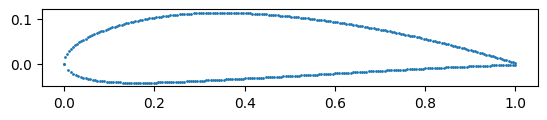

In [13]:
airfoil = af.Airfoil.NACA4("4415", n_points=200)
af_xs, af_ys = airfoil.all_points
plt.scatter(af_xs, af_ys, 1)
plt.axis('scaled')

# Wing Geometry

In [14]:
def linSpan(sp, Ni):
    return np.linspace(0, sp, Ni)


def uniformChord(Ni, ch=1):
    return ch * np.ones(Ni)


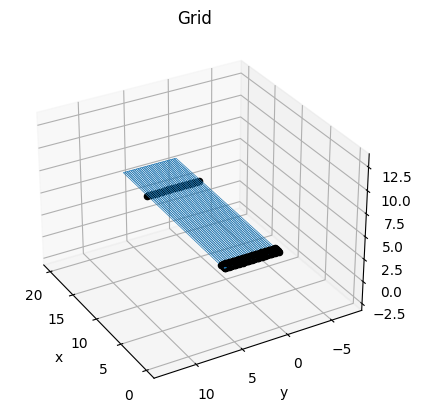

In [24]:
N = 30
M = 17
wg = Wing(
    airfoil=airfoil,
    isSymmetric=True,
    span=6,
    alpha=2,
    beta=40,
    Ni=N,
    Nj=M,
    sweepOffset=0,
    dihAngle=0,
    chordFun=uniformChord,
    spanFun=linSpan
)
wg.plotgrid()

## Wind

In [25]:
Umag = 20
dens = 1.225
Uinf = Umag * np.cos(wg.alpha) * np.cos(wg.beta)
Vinf = Umag * np.cos(wg.alpha) * np.sin(wg.beta)
Winf = Umag * np.sin(wg.alpha) * np.cos(wg.beta)
Q = np.array((Uinf, Vinf, Winf))


## Solve

In [26]:
a_np , b_np , RHS_np = wg.solveWingPanels(Q,pot.voring)

In [27]:
Gammas = np.linalg.solve(a_np, RHS_np)
Gammas_mat = Gammas.reshape((N-1, M-1))[:, :-1]
Gammas = Gammas_mat.reshape(((N-1)*(M-2)))
w = np.matmul(b_np, Gammas)
w_mat = w.reshape((N-1, M-2))

In [28]:
L_pan = np.zeros((N-1, M-2))
D_pan = np.zeros((N-1, M-2))
for i in np.arange(0, N-1):
    for j in np.arange(0, M-2):
        dy = wg.grid[i+1, j, 1] - wg.grid[i, j, 1]
        if j == 0:
            g = (Gammas_mat[i, j+1] - Gammas_mat[i, j])
        else:
            g = (Gammas_mat[i, j] - Gammas_mat[i, j-1])
        L_pan[i, j] = dens * Umag * dy * g
        D_pan[i, j] = -0.5 * dens * w_mat[i, j] * dy * g

In [29]:
L = np.sum(L_pan)
D = np.sum(D_pan)
print(f"Using No Penetration\nL:{L}\t|\tD:{D}")
print(f"CL:{2*L/(dens*(Umag**2)*wg.wingArea)}\t|\tCD_ind:{2*D/(dens*(Umag**2)*wg.wingArea)}")


Using No Penetration
L:520.0091160038419	|	D:33.87793804100282
CL:0.35374769796179717	|	CD_ind:0.023046216354423683


In [21]:
Dnew = np.zeros((N-1, M-2))
Gammas = np.linalg.solve(a_np, RHS_np)
Gammas_mat = Gammas.reshape((N-1, M-1))

for i in np.arange(0, N-1):
    for j in np.arange(0, M-2):
        dy = wg.grid[i+1, j, 1] - wg.grid[i, j, 1]
        if j == 0:
            g = (Gammas_mat[i, j+1] - Gammas_mat[i, j])
        else:
            g = (Gammas_mat[i, j] - Gammas_mat[i, j-1])
        U = 0
        _, Ui = wg.InducedVelocities(pot.voring,i,j,Gammas_mat)
        
        alfi = Ui[2] / Umag
        Dnew[i,j] = -dens * dy * Umag * g * alfi
D = np.sum(Dnew)
print(f"Using No Penetration\nL:{L}\t|\tD:{D}")
print(f"CL:{2*L/(dens*(Umag**2)*wg.wingArea)}\t|\tCD_ind:{2*D/(dens*(Umag**2)*wg.wingArea)}")


Using No Penetration
L:668.5108333826415	|	D:1.211824143346665
CL:0.4547692744099601	|	CD_ind:0.0008243701655419488


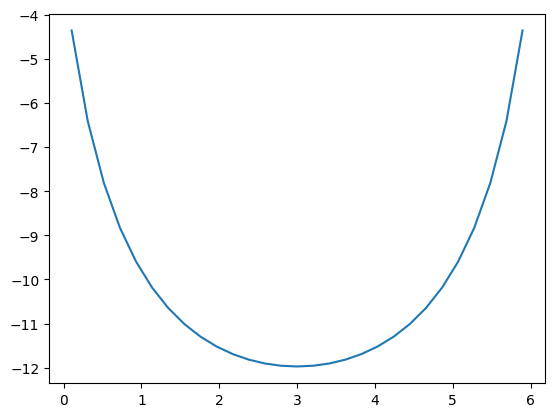

In [23]:
g = np.mean(w_mat, axis=1)
plt.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, g)


# ΑΟΑ

In [ ]:
LvsSweep = []
DvsSweep = []
D2vsSweep = []

GammavsSweep = []
WindvsSweep = []
offsets = np.linspace(0, 3, 10)
for offset in offsets:
    print(offset)
    wg = Wing(
        airfoil=airfoil,
        isSymmetric=True,
        span=6,
        alpha=5,
        beta=0,
        Ni=N,
        Nj=M,
        sweepOffset=offset,
        dihAngle=0,
        chordFun=uniformChord,
        spanFun=linSpan
    )    
    a_np, b_np, RHS_np = wg.solveWingPanels(Q, pot.voring)
    
    Gammas = np.linalg.solve(a_np, RHS_np)
    Gammas_mat = Gammas.reshape((N-1, M-1))[:, :-1]
    Gammas = Gammas_mat.reshape(((N-1)*(M-2)))
    w = np.matmul(b_np, Gammas)
    w_mat = w.reshape((N-1, M-2))
    L_pan = np.zeros((N-1, M-2))
    D_pan = np.zeros((N-1, M-2))
    for i in np.arange(0, N-1):
        for j in np.arange(0, M-2):
            dy = wg.grid[i+1, j, 1] - wg.grid[i, j, 1]
            if j == 0:
                g = (Gammas_mat[i, j+1] - Gammas_mat[i, j])
            else:
                g = (Gammas_mat[i, j] - Gammas_mat[i, j-1])
            L_pan[i, j] = dens * Umag * dy * g
            D_pan[i, j] = -0.5 * dens * w_mat[i, j] * dy * g
    L = np.sum(L_pan)
    D = np.sum(D_pan)
    print(f"Using No Penetration\nL:{L}\t|\tD:{D}")
    print(f"CL:{2*L/(dens*(Umag**2)*wg.wingArea)}\t|\tCD_ind:{2*D/(dens*(Umag**2)*wg.wingArea)}")

    Dnew = np.zeros((N-1, M-2))
    Gammas = np.linalg.solve(a_np, RHS_np)
    Gammas_mat = Gammas.reshape((N-1, M-1))


    LvsSweep.append(L)
    DvsSweep.append(D)
    GammavsSweep.append(Gammas_mat)
    WindvsSweep.append(w_mat)

LvsSweep = np.array(LvsSweep)
DvsSweep = np.array(DvsSweep)
# GammavsSweep = np.array(GammavsSweep)
# WindvsSweep = np.array(WindvsSweep)


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Angle of Attack Effect on Lift And Drag')

ax1.plot(offsets, LvsSweep)
ax1.set_xlabel("AoA")
ax1.set_title("Lift")
ax1.minorticks_on()
ax1.grid()

ax2.plot(offsets, DvsSweep)
ax1.set_xlabel("AoA")
ax2.set_title("Drag")
ax2.minorticks_on()
ax2.grid()

fig.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Results')
for i, offset in enumerate(offsets):
    # , label="offset {:.2f}".format(offset))
    g = np.mean(GammavsSweep[i], axis=1)
    ax1.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2, g)

    ax1.set_xlabel("span")
    ax1.set_title("Gamma")

    w = np.mean(WindvsSweep[i], axis=1)
    ax2.plot((wg.Dspan[1:] + wg.Dspan[:-1])/2,
             w, label="offset {:.2f}".format(offset))

    ax2.set_xlabel("span")
    ax2.set_title("w_ind")
ax1.legend(loc="lower right")
ax1.grid(which='minor', linewidth=0.1)
ax1.grid(which='major', linewidth=1)
ax1.minorticks_on()

ax2.legend(loc="upper right")
ax2.grid(which='minor', linewidth=0.1)
ax2.grid(which='major', linewidth=1)
ax2.minorticks_on()
fig.show()
